In [935]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
from biokit.viz import corrplot
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from sklearn import tree
from sklearn import neighbors 
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from time import clock
import fancyimpute
import xgboost as xgb
from statsmodels.graphics.mosaicplot import mosaic
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Current Features

In [936]:
#import our data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
data = pd.concat([train, test])

### Title
Extract the Title of each passenger using regular expressions. Regular expressions (also refered to as regex) is a sequence of characters that define and search for a pattern in a string.  Also note that from now on I will be using a combined version of our data (both train and test data) so that I won't have to rewrite code to create the test set features.

In [937]:
# Here is a pivot table with the Titles and the gender. Note that there should be a 
# high correlation between the two variables but that is ok for now.
titles = []
for name in data.Name:
    titles.append(re.search(r'[A-Z][a-z]+\.', name).group())
data['Title'] = titles
pd.crosstab(data['Sex'], data['Title'],rownames=['Gender'], colnames=['Title'])

Title,Capt.,Col.,Countess.,Don.,Dona.,Dr.,Jonkheer.,Lady.,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.,Sir.
Gender,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [938]:
# Try modifying the titles a bit
#There are some titles with very few counts. We could group those into a collection of rare titles
rare = ["Capt.", "Col.", "Countess.", "Don.", "Dona.", "Jonkheer.", "Dr.", "Dr.", "Major.", "Rev.", "Sir.", "Lady."]
for i in range(len(titles)):
    if titles[i] in rare:
        titles[i]='rare'
data['Title']=titles

In [939]:
# Also reassign mlle, ms, and mme, lady accordingly
data = data.replace(to_replace='Mlle.', value='Miss.')
data = data.replace(to_replace='Ms.', value='Miss.')
data = data.replace(to_replace='Mme.', value='Mrs.')

In [940]:
#Our new pivot table looks like this
pd.crosstab(data['Sex'], data['Title'],rownames=['Gender'], colnames=['Title'])

Title,Master.,Miss.,Mr.,Mrs.,rare
Gender,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


In [941]:
# Survival in this case does not seem to depend to much on the title. perhaps we should revisit that feature to make 
# it more informative.
pd.crosstab(data['Survived'], data['Title'],rownames=['Survived'], colnames=['Title'])

Title,Master.,Miss.,Mr.,Mrs.,rare
Survived,,,,,
0,17,55,436,26,15
1,23,130,81,100,8


### Family Size
Now we will examine family sizes. Some intuition behind this is that families with children may have escaped the disaster if they were given priority when abandoning the sinking ship.

In [942]:
# family size for each passenger
data['Fsize'] = np.array(data['Parch'])+np.array(data['SibSp']) + 1

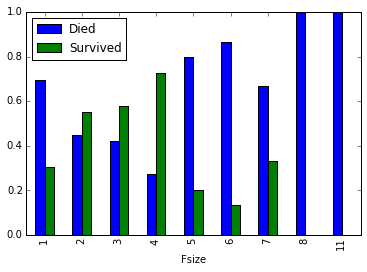

In [943]:
# Now let's explore the relation between family size and survival rate
survived = data[data['Survived']==1]
died = data[data['Survived']==0]
died['Died'] = 1
died.drop("Survived", axis=1, inplace=True)
survived = survived.groupby('Fsize')[['Survived']].sum()
died = died.groupby('Fsize')[['Died']].sum()
result = pd.concat([died, survived], axis=1)
result = result.fillna(0)
# convert to proportions
total = np.array(result['Died'])+np.array(result['Survived'])
result['Died'] = np.array(result["Died"])/total
result['Survived'] = np.array(result["Survived"])/total
result.plot(kind='bar')

In [944]:
# clearly we see that the only types of families that survived are mainly those of 2, 3 and 4 people while others seem
# to have perished
#Hence, we can encode the family size into 3 categorical variables, small, medium and large based on their size
def encode_fsize(x):
    if x==1:
        return 'small'
    elif x<5:
        return 'medium'
    else:
        return 'large'

In [945]:
data['Fsize']=data['Fsize'].apply(encode_fsize)

In [946]:
data.drop(['SibSp','Parch'], axis=1, inplace=True)

### Deck

In [947]:
# In this part we will utilize the cabin variable that we have to see what was the deck of each passenger
# Z if value is nan
data['Deck'] = data['Cabin'].apply(lambda x: x[0] if type(x)==type('str') else 'Z')
data.drop('Cabin', axis=1, inplace=True)

### Ticket prefix

In [948]:
data['TicketPrefix'] = data["Ticket"].apply(lambda i: i.split(" ")[0] if len(i.split(" "))>=2 else '0')

In [949]:
data['TicketPrefix'] = data['TicketPrefix'].apply(lambda x: re.sub(r'[/\.]', "", x))

### Fare

In [950]:
class_port_means = pd.crosstab(data['Pclass'], data['Embarked'], values = data['Fare'], aggfunc='mean',
                               rownames=['Pclass'], colnames=['Title'])

In [951]:
new_fares = []
for i in range(len(data)):
    if np.array(data['Fare'])[i]<5 or np.isnan(np.array(data['Fare'])[i]):
        new_fares.append(class_port_means[np.array(data.Embarked)[i]][np.array(data.Pclass)[i]])
    else:
        new_fares.append(np.array(data['Fare'])[i])
data['Fare'] = new_fares

In [952]:
data['Embarked'] = data['Embarked'].fillna("S")

### Age 

In [953]:
not_nan_third_class = data[data.notnull()['Age']]
not_nan_third_class = not_nan_third_class[not_nan_third_class['Pclass']==3]
data['Age'] = data['Age'].fillna(np.mean(not_nan_third_class['Age']))

In [954]:
#encode Sex
data.Sex = data['Sex'].apply(lambda x: 1 if x=="female" else 0)

# New Features

In [955]:
# Ticket counts put nan if only 1 person had this ticket
combined_tickets = data.groupby("Ticket").size().to_dict()
data['Ticket'] = data['Ticket'].apply(lambda x: combined_tickets[x] if combined_tickets[x]>1 else np.nan)

In [956]:
# Families on board
data['LastName'] = data['Name'].apply(lambda name: name.split(',')[0])
data = data.assign(Family = lambda x: [a + '_' + str(b) for a, b in zip(
                    list(x.LastName), list(x.Fsize))])

## Convert to dummies

In [957]:
data = data.pipe(pd.get_dummies, columns = ['Pclass', 'Title', 'Ticket', 'Deck', 'Embarked', 'TicketPrefix', 'Family',
                                            'Fsize'])
data.drop(['PassengerId', 'Name', 'LastName'], axis=1,inplace=True)

In [959]:
#sklearn preprocessing
# Note that the values derived are not exactly 0 or 1 but are awefully close to those values.
for col in data.drop(["Survived"], axis=1).axes[1]:
    if len(collections.Counter(data[col]).keys())>2:
        data[col] = preprocessing.scale(data[col])

### Data formatting
Put the data in the correct format to train our classifiers.

### Predictions

In [960]:
train = data[:len(train)]
test = data[len(train):]

In [961]:
X=train.drop('Survived', axis=1).as_matrix()
Y= np.array(train['Survived'])

In [962]:
#At this point we will define a utility function which will abstract away some of the code for us
def report(clf, X, Y):
    start=clock()
    predicted = cross_validation.cross_val_predict(clf, X, Y, cv=10)
    end = clock()
    print("Accuracy: ", metrics.accuracy_score(Y, predicted))
    print("Recall: ", metrics.recall_score(Y, predicted))
    print("Precision: ", metrics.precision_score(Y, predicted))
    print("F1: ", metrics.f1_score(Y, predicted))
    print("Time elapsed: ", end-start)

In [963]:
# 78% on the leader leaderboard
rf_model = ensemble.RandomForestClassifier(min_samples_split=3, max_depth=None, min_samples_leaf=1)
report(rf_model, X, Y)

Accuracy:  0.828282828283
Recall:  0.716374269006
Precision:  0.813953488372
F1:  0.762052877138
Time elapsed:  0.4888700000001336


In [964]:
# 79% on the leader leaderboard
lr_model = linear_model.LogisticRegression(C=10,class_weight='balanced')
report(lr_model, X, Y)

Accuracy:  0.837261503928
Recall:  0.783625730994
Precision:  0.790560471976
F1:  0.787077826725
Time elapsed:  0.36422699999911856


In [965]:
# 78% on the leader leaderboard
svm_model = svm.SVC(kernel = 'rbf',C=1000, gamma=0.0001, probability=True)
report(svm_model, X, Y)

Accuracy:  0.835016835017
Recall:  0.736842105263
Precision:  0.815533980583
F1:  0.774193548387
Time elapsed:  23.392264999999497


In [966]:
# 76% on the leaderboard
xgboost_model = xgb.XGBClassifier(reg_alpha=0.01, max_depth=3, gamma=0.1, min_child_weight=1)
report(xgboost_model, X, Y)

Accuracy:  0.835016835017
Recall:  0.733918128655
Precision:  0.817589576547
F1:  0.773497688752
Time elapsed:  15.897245000000112


In [967]:
knn = neighbors.KNeighborsClassifier(n_neighbors=7)
report(knn, X,Y)

Accuracy:  0.828282828283
Recall:  0.728070175439
Precision:  0.805825242718
F1:  0.764976958525
Time elapsed:  1.1595989999996164


In [972]:
# 0.82 on the leaderboard -- best so far
combined_hard = ensemble.VotingClassifier([('1', rf_model), ('2', lr_model), ('3', svm_model)], voting='hard',
                                     weights=[1,2,1])
report(combined_hard, X, Y)

Accuracy:  0.849607182941
Recall:  0.75730994152
Precision:  0.835483870968
F1:  0.794478527607
Time elapsed:  29.983655


In [883]:
#77% on leaderboard
combined_soft = ensemble.VotingClassifier([('1', rf_model), ('2', lr_model), ('3', svm_model)], voting='soft',
                                     weights=[1,2,1])
report(combined_soft, X, Y)

Accuracy:  0.845117845118
Recall:  0.766081871345
Precision:  0.81875
F1:  0.791540785498
Time elapsed:  27.8567350000003


In [682]:
combined = ensemble.VotingClassifier([('1', rf_model), ('2', lr_model), ('3', svm_model), ('4', xgboost_model)],
                                     voting='hard', weights=[1,2,1,1])
report(combined, X, Y)

Accuracy:  0.842873176207
Recall:  0.760233918129
Precision:  0.817610062893
F1:  0.787878787879
Time elapsed:  45.9600930000006


## Submission

In [969]:
combined_hard.fit(X, Y)
combined_hard_preds = combined_hard.predict(test.drop('Survived', axis=1))

In [970]:
def make_submission_file(filename, predictions):
    results = pd.DataFrame()
    results['Survived'] = [int(i) for i in predictions]
    results['PassengerId'] = np.arange(892, 892+418)
    results.to_csv(filename,index=False)

In [971]:
#make submission
filename = "predictions/test.csv"
make_submission_file(filename, combined_hard_preds)

In [691]:
# #make a soft classifier which takes the weighted average 
# #uses cross validation
# def soft_voting(clfs, X, Y, weights="", n_folds = 10, boundary=0.5):
#     if weights=="":
#         weights = [1]*len(clfs)
#     skf = cross_validation.StratifiedKFold(Y, n_folds=n_folds, shuffle=True)
#     y_pred = []
#     y_true = []
#     for train_index, test_index in skf:
#         y = np.zeros(len(test_index))
#         train_X, train_Y = X[train_index], Y[train_index]
#         test_X, test_Y = X[test_index], Y[test_index]
#         for i in clfs:
#             clf=i
#             if type(clf)==type(svm.SVC()):
#                 try:
#                     clf.fit(train_X, train_Y)
#                 except:
#                     print(clf)
#             else:
#                 clf.fit(train_X, train_Y)
#             y = y + clf.predict_proba(test_X)
#         y_pred.extend(y/len(clfs))
#         y_true.extend(clf.predict(test_Y))
#     y_pred = [1 if i>=0.5 else 0 for i in y_pred]
#     return metrics.accuracy_score(y_pred, y_true)